In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from descriptors.sf.get_sf_param import get_sf_radial_params
from ase.io import read
import os

from constants.constants import get_silicon_all_scf_data_sd
from descriptors.sf.get_sf_value import SfFuncVal

In [105]:
rcut = 5
param_df = get_sf_radial_params(elm=['Si'], rcut=rcut, nb_param_pairs=6)
g2_params = param_df[['eta', 'rs']].values

In [106]:
from descriptors.sf.get_sf_param import get_sf_ang_params

ang_param_df = get_sf_ang_params(
    elm=['Si'],
    rcut=rcut,
    nb_param_pairs=2,
    ang_type='angular_narrow',
    zetas=[1, 4, 8],
    r_lower=3
)
g4_params = ang_param_df[['eta', 'zeta', 'lam']].values

In [107]:
# all_structures = get_silicon_all_scf_data_sd()

with open('/Users/y1u0d2/desktop/Lab/result/n2p2/Si/90/data/dirs.txt', mode='r') as f:
    all_structures = [s.strip() for s in f.readlines()]

print(len(all_structures))

54615


In [108]:
all_structures = list(filter(lambda x: 'dimer' not in x, all_structures))
print(len(all_structures))

54577


In [109]:
from scf.qelattice import get_qel
import random

sample_size = 100
df_list = []

for i, path2structure in enumerate(random.sample(all_structures, sample_size)):
    try:
        qel = get_qel(path2structure)
        force_df = pd.DataFrame(data=qel.get_force(), columns=['fx', 'fy', 'fz'])
    except Exception as e:
        print(e, path2structure)
        continue

    structure = read(os.path.join(path2structure, 'scf.in'), format='espresso-in')
    symbols = ['Si' for _ in range(structure.get_global_number_of_atoms())]
    structure.set_chemical_symbols(symbols)

    df_sf = SfFuncVal.get_g2_value(
        g2_params=g2_params,
        structure=structure,
        species=['Si', 'Si'],
        rcut=rcut,
        periodic=False
        )
    
    df_sf_ang = SfFuncVal.get_g4_value(
        g4_params=g4_params,
        structure=structure,
        species=['Si', 'Si', 'Si'],
        rcut=rcut,
        periodic=False
        )
    
    df_list.append(pd.concat([df_sf, df_sf_ang, force_df], axis=1))

In [110]:
all_sf_df = pd.concat(df_list)
all_sf_df.drop(columns=['g1'], inplace=True)

In [111]:
print(len(all_sf_df))

1592


In [112]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

feature_cols = [col for col in all_sf_df.columns if 'eta' in col]
target_cols = ['fx', 'fy', 'fz']

print(feature_cols)

feature_df = all_sf_df[feature_cols].copy()
target_df = all_sf_df[target_cols].copy()

X_train, X_test, y_train, y_test = train_test_split(feature_df.values, target_df.values, test_size=0.8, random_state=42)

['eta-11.89_rs-0.8333_rcut-5', 'eta-6.543_rs-1.123_rcut-5', 'eta-3.601_rs-1.514_rcut-5', 'eta-1.982_rs-2.041_rcut-5', 'eta-1.091_rs-2.752_rcut-5', 'eta-0.6002_rs-3.709_rcut-5', 'eta-0.05556_zeta-1.0_lam--1.0_rcut-5', 'eta-0.05556_zeta-1.0_lam-1.0_rcut-5', 'eta-0.05556_zeta-4.0_lam--1.0_rcut-5', 'eta-0.05556_zeta-4.0_lam-1.0_rcut-5', 'eta-0.05556_zeta-8.0_lam--1.0_rcut-5', 'eta-0.05556_zeta-8.0_lam-1.0_rcut-5', 'eta-0.02_zeta-1.0_lam--1.0_rcut-5', 'eta-0.02_zeta-1.0_lam-1.0_rcut-5', 'eta-0.02_zeta-4.0_lam--1.0_rcut-5', 'eta-0.02_zeta-4.0_lam-1.0_rcut-5', 'eta-0.02_zeta-8.0_lam--1.0_rcut-5', 'eta-0.02_zeta-8.0_lam-1.0_rcut-5']


In [113]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

feature_cols = [col for col in all_sf_df.columns if 'eta' in col]
target_cols = ['fx', 'fy', 'fz']

feature_df = all_sf_df[feature_cols].copy()
target_df = all_sf_df[target_cols].copy()

X_train, X_test, y_train, y_test = train_test_split(feature_df.values, target_df.values, test_size=0.8, random_state=42)

In [114]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [115]:
from tensorflow.keras.models import Sequential
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
    tf.keras.layers.Dense(20, activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
    tf.keras.layers.Dense(3, activation='linear')
], name='mlp')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mae'])

In [116]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, verbose=1)]

history = model.fit(X_train_scaled, y_train, batch_size=32, epochs=20,
                    validation_split=0.2, callbacks=callbacks)

Epoch 1/20
8/8 [==============================] - 1s 22ms/step - loss: 18.0552 - mae: 2.4046 - val_loss: 13.7906 - val_mae: 2.1565
Epoch 2/20
8/8 [==============================] - 0s 4ms/step - loss: 17.4228 - mae: 2.3879 - val_loss: 13.1197 - val_mae: 2.0578
Epoch 3/20
8/8 [==============================] - 0s 4ms/step - loss: 17.0176 - mae: 2.3257 - val_loss: 13.2326 - val_mae: 2.0690
Epoch 4/20
8/8 [==============================] - 0s 4ms/step - loss: 16.7296 - mae: 2.3143 - val_loss: 12.9395 - val_mae: 2.0392
Epoch 5/20
8/8 [==============================] - 0s 4ms/step - loss: 16.5792 - mae: 2.3240 - val_loss: 12.6984 - val_mae: 2.0494
Epoch 6/20
8/8 [==============================] - 0s 4ms/step - loss: 16.3617 - mae: 2.3537 - val_loss: 13.0553 - val_mae: 2.1034
Epoch 7/20
8/8 [==============================] - 0s 4ms/step - loss: 15.7011 - mae: 2.3078 - val_loss: 12.3444 - val_mae: 2.0438
Epoch 8/20
8/8 [==============================] - 0s 4ms/step - loss: 16.0128 - mae: 2.33

In [117]:
model.summary()

Model: "mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 20)                380       
                                                                 
 dense_13 (Dense)            (None, 20)                420       
                                                                 
 dense_14 (Dense)            (None, 3)                 63        
                                                                 
Total params: 863
Trainable params: 863
Non-trainable params: 0
_________________________________________________________________


In [118]:
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)

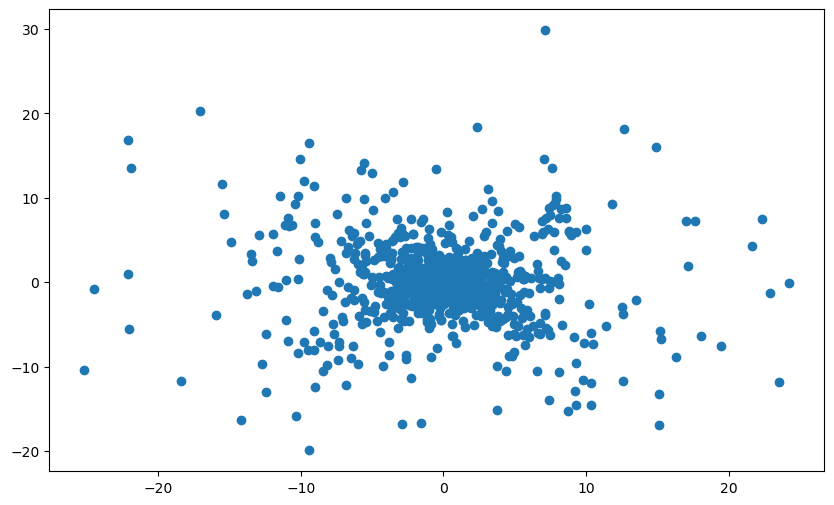

In [119]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.scatter(target_df.values[:, 0], target_df.values[:, 1])

10/10 [==============================] - 0s 859us/step


(-30.0, 30.0)

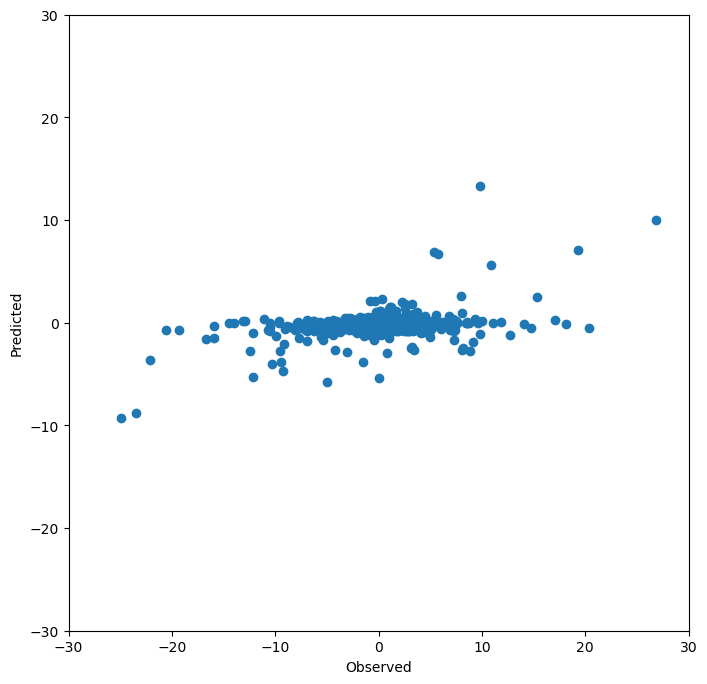

In [120]:
y_train_predicted = model.predict(X_train_scaled)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

ax.scatter(np.ravel(y_train), np.ravel(y_train_predicted))
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')

ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)

40/40 [==============================] - 0s 701us/step


(-30.0, 30.0)

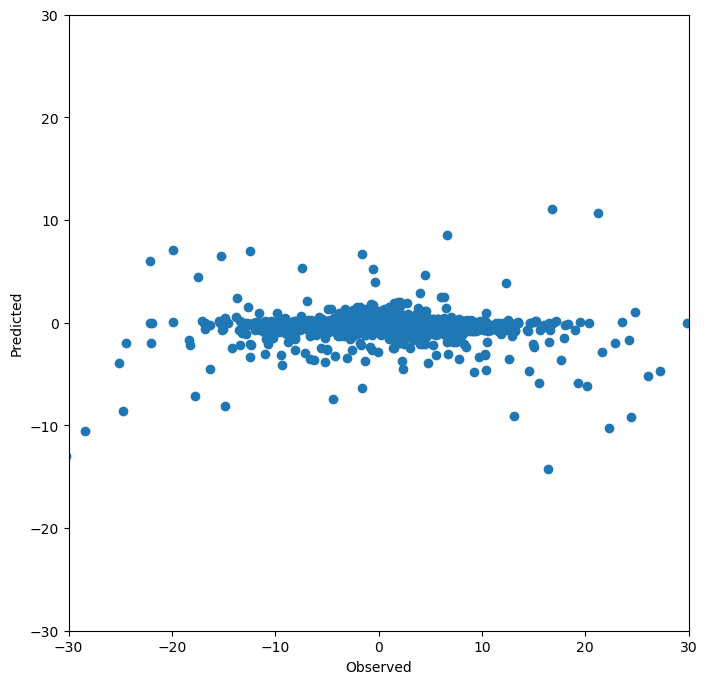

In [121]:
y_test_predicted = model.predict(X_test_scaled)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

ax.scatter(np.ravel(y_test), np.ravel(y_test_predicted))
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')

ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)

<AxesSubplot: ylabel='Frequency'>

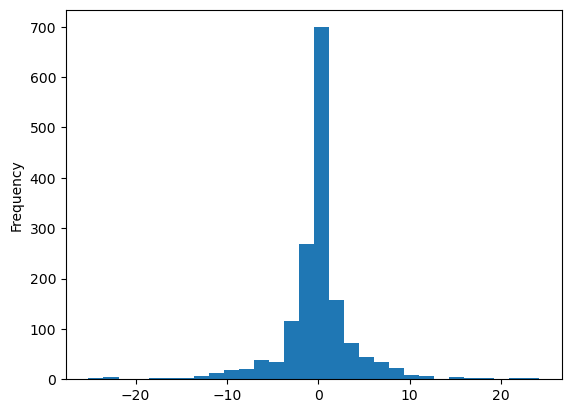

In [122]:
target_df['fx'].plot.hist(bins=30)

In [123]:
target_df['fx_scaled'] = np.log(target_df['fx'])

/Users/y1u0d2/opt/anaconda3/envs/ml/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [164]:
G = tf.Variable(X_train_scaled)

with tf.GradientTape() as tape:
  # y = model.predict(G.numpy())
  y = model(G)

g = tape.gradient(y, G)

<tf.Tensor: shape=(318, 18), dtype=float32, numpy=
array([[-1.4298231e-02, -1.5547865e-02, -1.7378664e-02, ...,
        -4.2878353e-04,  2.0912679e-02, -3.5809041e-03],
       [-3.1857449e-01, -4.9788269e-01, -3.9753467e-01, ...,
        -4.3286169e-01,  1.8141571e-01, -2.7272308e-01],
       [-2.7260381e-01, -4.8857671e-01, -3.0922392e-01, ...,
        -3.8976794e-01,  1.9931756e-01, -2.2620794e-01],
       ...,
       [-5.8076954e-01, -7.3278534e-01, -5.2062488e-01, ...,
        -4.8295844e-02,  4.3369913e-01,  8.7493099e-03],
       [-2.0136587e-02, -2.7666893e-02, -3.2267056e-02, ...,
         3.0163545e-03,  1.9948648e-02,  1.7857939e-02],
       [-1.6358243e-02, -2.3342315e-02, -2.5498660e-02, ...,
         1.6120654e-03,  1.8713417e-02,  1.6661242e-02]], dtype=float32)>